In [1]:

import numpy as np
import torch 
import torch.nn as nn
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader

import sys
from pprint import pprint
from pathlib import Path
sys.path.insert(0, r"C:\Users\isakb\Documents\M.Sc Physics\Code\GNN_decoder_quant")

from src.simulations import SurfaceCodeSim
from src.graph_representation import get_3D_graph
from src.gnn_models import QGNN_7, GNN_7

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from icecream import ic
ic.configureOutput(includeContext=True)

#### Settings

In [2]:
model_path = Path.cwd().parent / Path("models\circuit_level_noise\d5\d5_d_t_3.pt")
device = torch.device("cpu")
n_graphs = 5000
seed = 11
batch_size = n_graphs if n_graphs < 5000 else 5000
p = 1e-3

# read code distance and number of repetitions from file name
file_name = model_path.name
splits = file_name.split("_")
code_sz = int(splits[0][1])
reps = int(splits[3].split(".")[0])

##### Create model and load pre-trained weights

In [3]:
from collections import OrderedDict
def get_matching_state_dict(model, trained_state_dict):
    
    new_dict = OrderedDict(trained_state_dict)
    for new_key, key in zip(model.state_dict().keys(), trained_state_dict.keys()):
        new_dict[new_key] = new_dict[key]
        del new_dict[key]
        
    return new_dict

In [4]:
model = GNN_7().to(device)
float_model = GNN_7().to(device)

trained_weights = torch.load(model_path, map_location=device)["model"]
trained_weights = get_matching_state_dict(model, trained_weights)
model.load_state_dict(trained_weights)
float_model.load_state_dict(trained_weights)

model.eval()
float_model.eval()

# aggregate layer weights and check their parameter range
layer_weights = []
for module in model.children():
    if isinstance(torch.nn.modules.container.ModuleList(), type(module)):
        for layer in module:
            if hasattr(layer, "lin_rel"):
                lin_rel = torch.flatten(layer.lin_rel.weight)
                lin_bias = torch.flatten(layer.lin_rel.bias)
                lin_root = torch.flatten(layer.lin_root.weight)
                layer_weights.extend([lin_rel, lin_bias, lin_root])
            else:
                layer_weights.append(layer.weight)
                layer_weights.append(layer.bias)
                
    else:
        if hasattr(module, "lin_rel"):
            lin_rel = torch.flatten(module.lin_rel.weight)
            lin_bias = torch.flatten(module.lin_rel.bias)
            lin_root = torch.flatten(module.lin_root.weight)
            layer_weights.extend([lin_rel, lin_bias, lin_root])
        else:
            layer_weights.append(module.weight)
            layer_weights.append(module.bias)
        

#### Visualise distribution of weights

C:\Users\isakb\AppData\Local\Temp\ipykernel_22616\1712960056.py:11: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots()


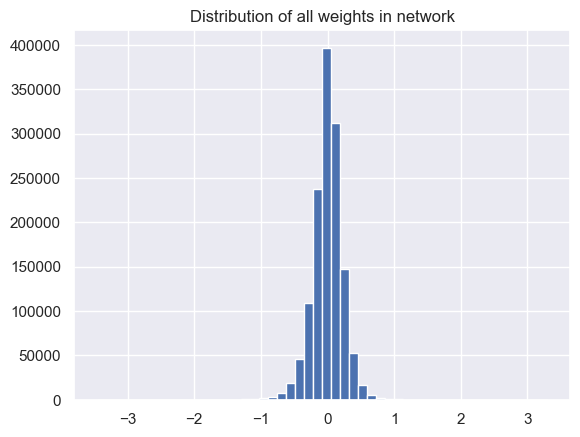

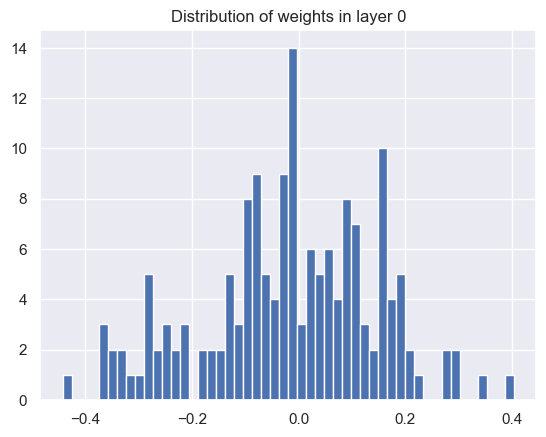

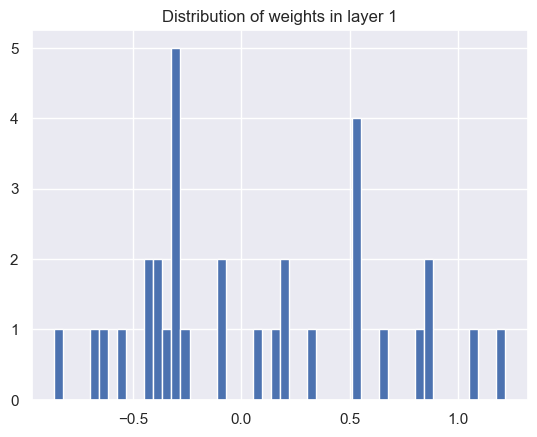

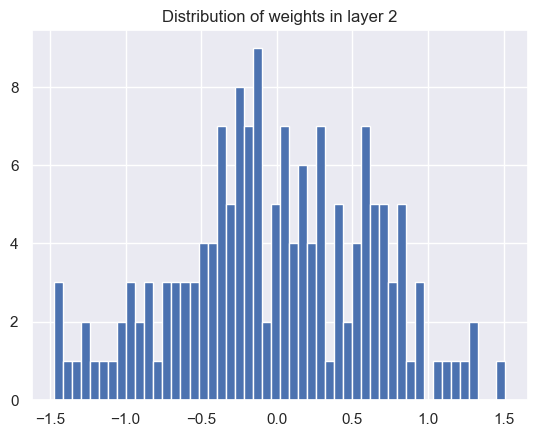

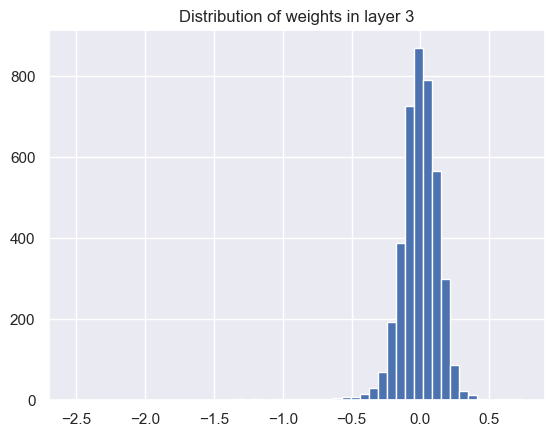

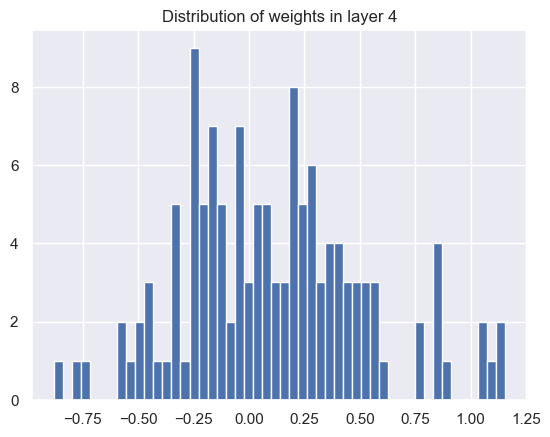

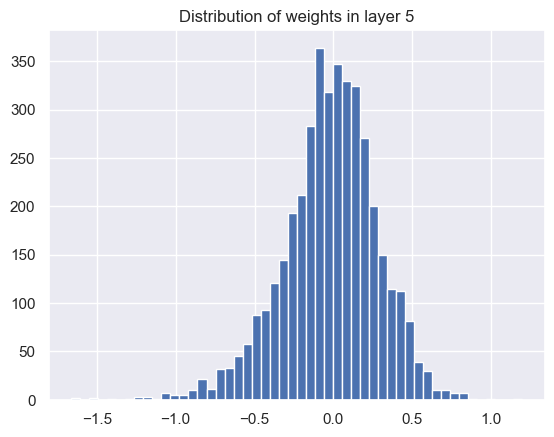

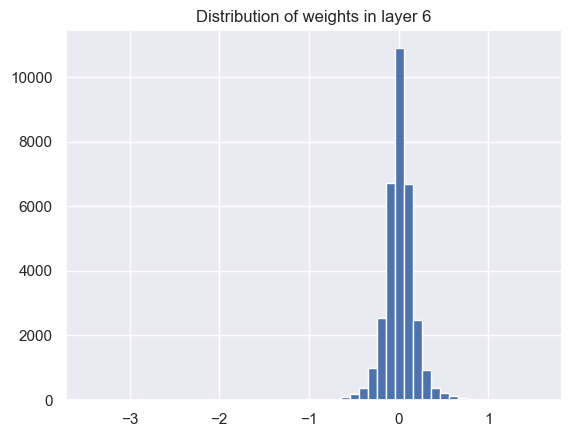

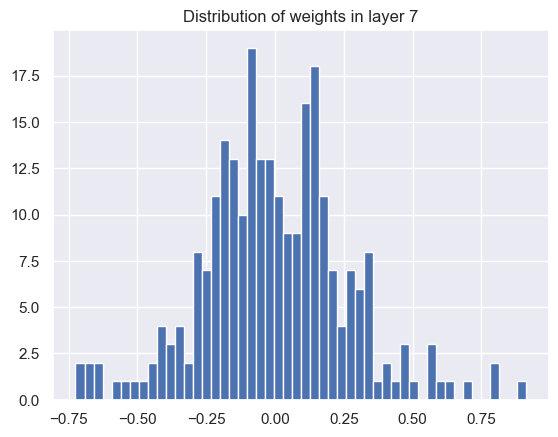

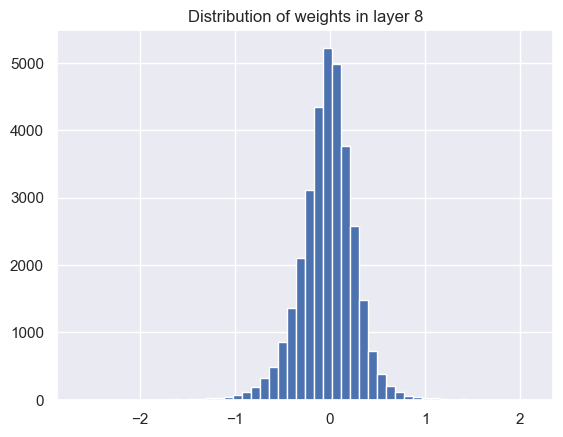

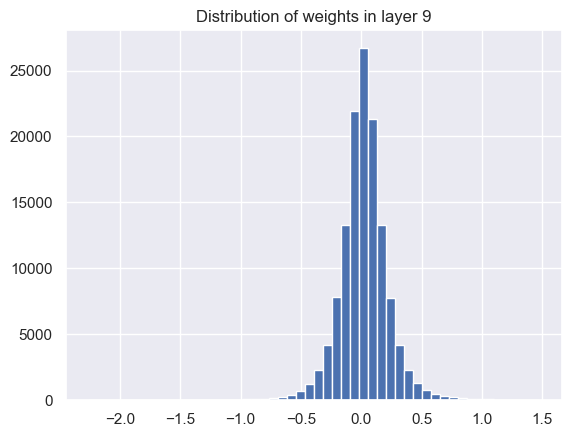

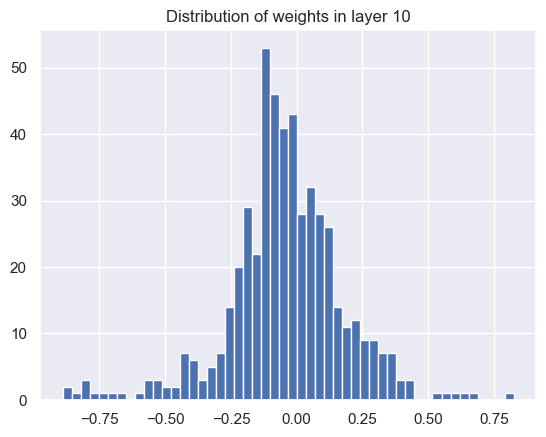

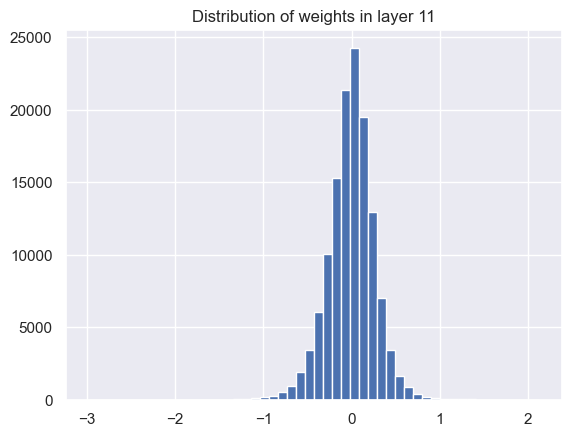

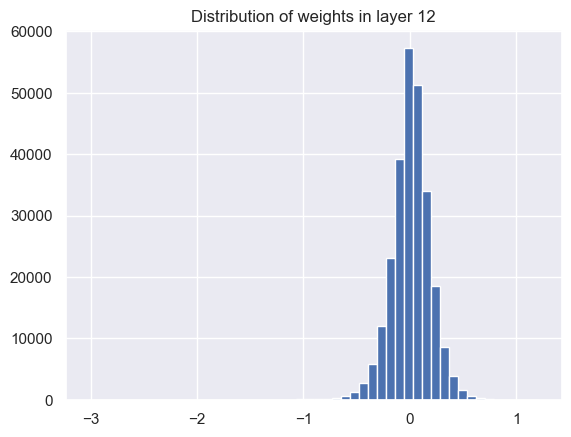

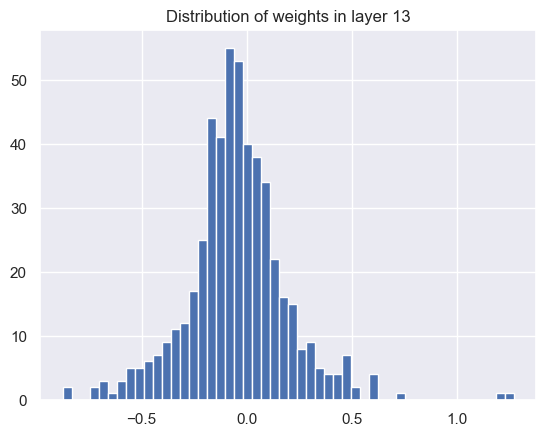

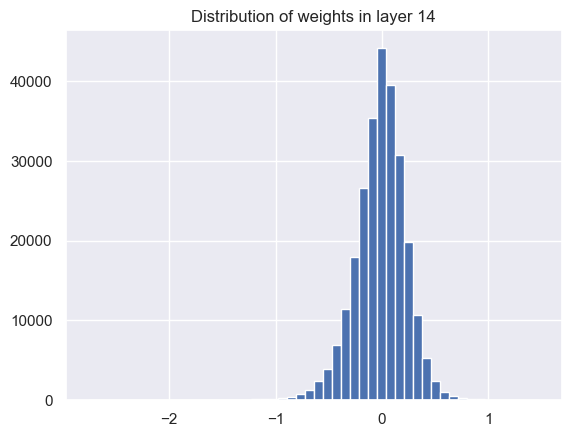

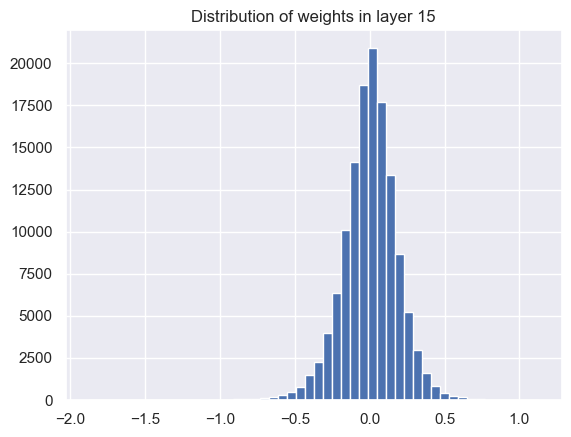

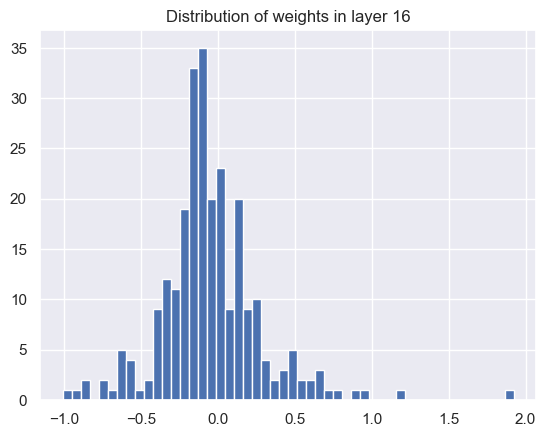

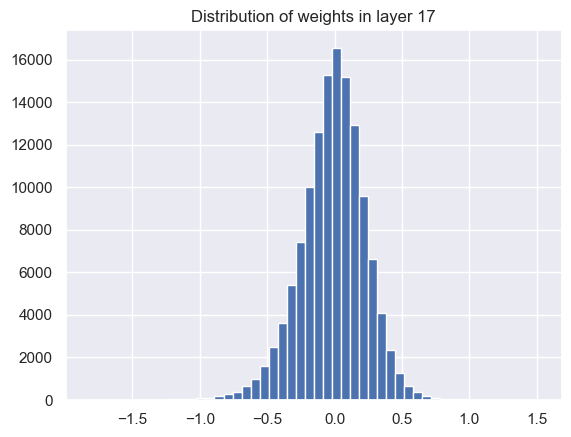

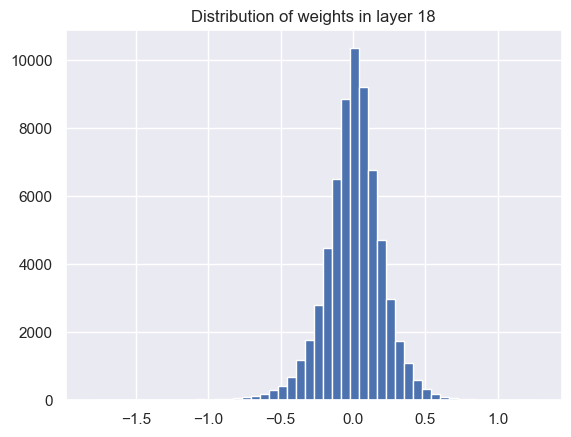

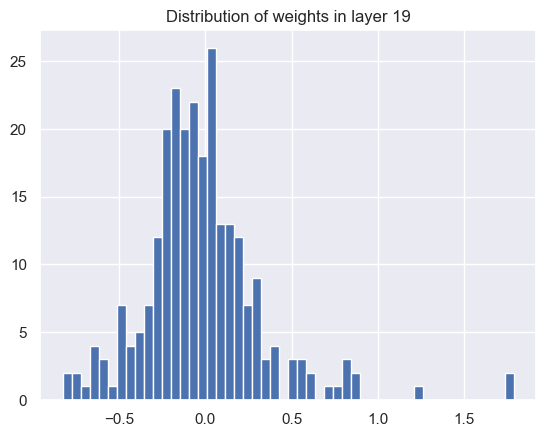

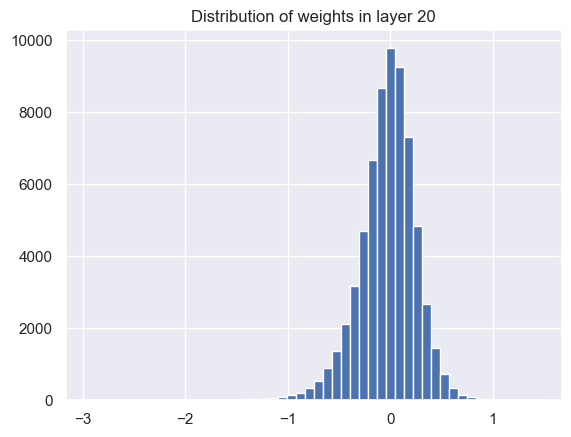

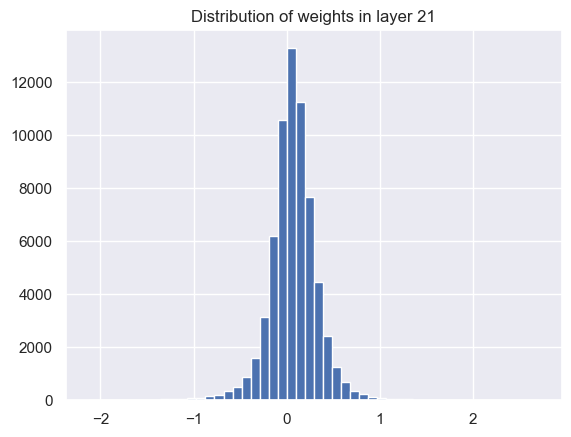

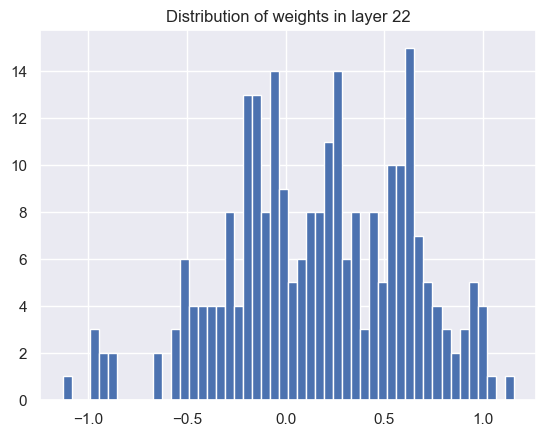

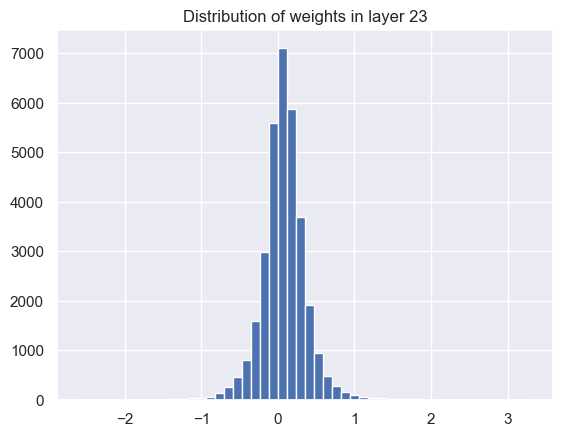

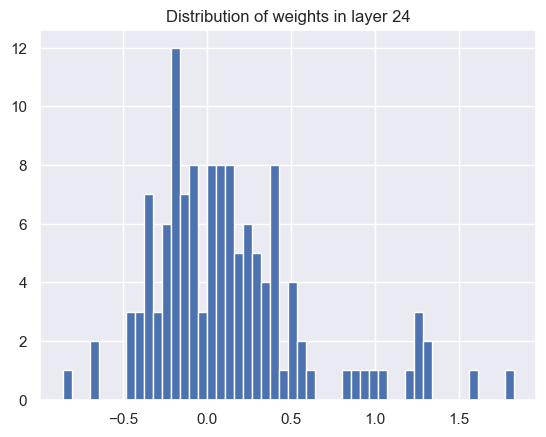

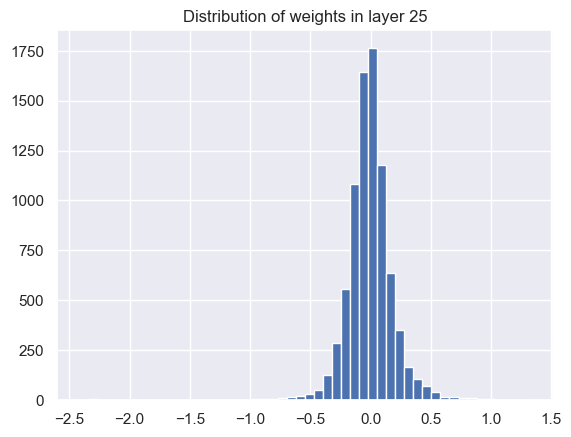

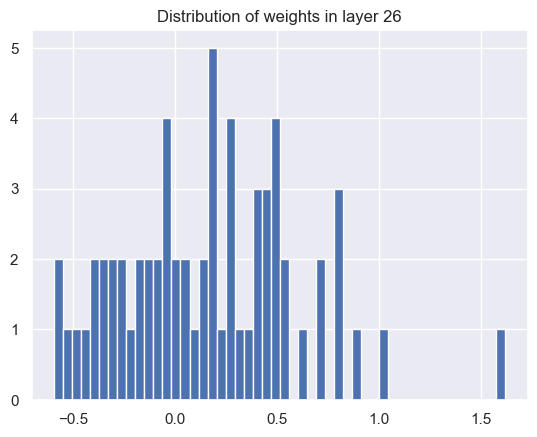

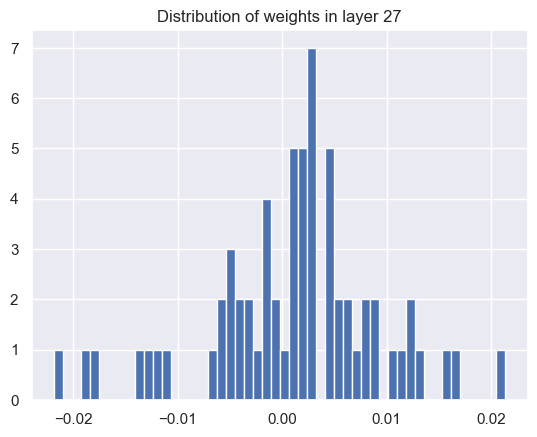

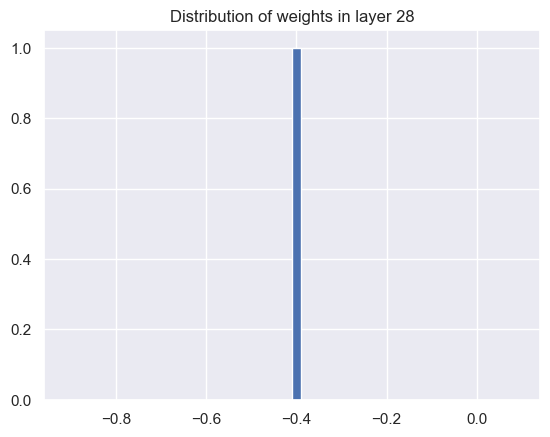

In [5]:
all_weights = np.concatenate(list(map(lambda x: torch.flatten(x).detach().numpy(), layer_weights)))

plot = True
if plot:
    n_bins = 50
    fig, ax = plt.subplots()
    ax.hist(all_weights, n_bins)
    ax.set_title("Distribution of all weights in network")

    for i, w in enumerate(layer_weights):
        fig, ax = plt.subplots()
        
        ax.hist(torch.flatten(w).detach().numpy(), n_bins)
        ax.set_title(f"Distribution of weights in layer {i}")

##### Utility functions to perform quantization (using signed integers)

In [6]:
def quantize_tensor(r, scale, zero_point):
    return torch.floor(r / scale + zero_point).char()

def unquantize_tensor(q, scale, zero_point):
    return (scale * (q - zero_point)).float()

def get_scale(alpha, beta, bit_width):
    return (beta - alpha) / (2 ** bit_width - 1)

def get_zero_pt(alpha, beta, bit_width):
    return torch.floor((2 ** bit_width * (alpha + beta) - 2 * beta) / (2 * (alpha - beta))).char()

##### Make sure quantization looks reasonable

A real zero is mapped to integer -42.


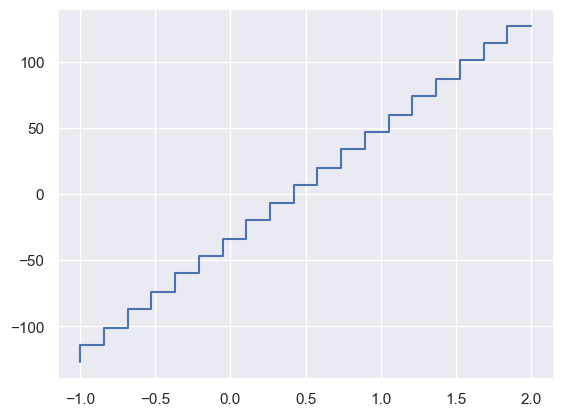

In [7]:
bit_width = 8
alpha = torch.tensor(-1)
beta = torch.tensor(2)

scale = get_scale(alpha, beta, bit_width)
zero_pt = get_zero_pt(alpha, beta, bit_width)

r = torch.tensor(np.linspace(alpha, beta, 20))
q = quantize_tensor(r, scale, zero_pt)

fig, ax = plt.subplots()
ax.step(r, q)

print(f"A real zero is mapped to integer {quantize_tensor(torch.tensor(0), scale, zero_pt).char()}.")

##### Attempt naive quantization

In [8]:
alpha = torch.tensor(all_weights).min()
beta = torch.tensor(all_weights).max()

scale = get_scale(alpha, beta, bit_width)
zero_pt = get_zero_pt(alpha, beta, bit_width)

with torch.no_grad():
    for module in model.children():
        if isinstance(torch.nn.modules.container.ModuleList(), type(module)):
            for layer in module:
                if hasattr(layer, "lin_rel"):
                    lin_rel = layer.lin_rel.weight
                    lin_bias = layer.lin_rel.bias
                    lin_root = layer.lin_root.weight

                    # alpha = torch.concatenate((torch.flatten(lin_rel), torch.flatten(lin_bias), torch.flatten(lin_root))).min()
                    # beta = torch.concatenate((torch.flatten(lin_rel), torch.flatten(lin_bias), torch.flatten(lin_root))).max()
                    # scale = get_scale(alpha, beta, bit_width)
                    # zero_pt = get_zero_pt(alpha, beta, bit_width)
                    layer.lin_rel.weight = nn.Parameter(
                        quantize_tensor(lin_rel, scale, zero_pt), requires_grad=False
                    )
                    layer.lin_rel.bias = nn.Parameter(
                        quantize_tensor(lin_bias, scale, zero_pt), requires_grad=False
                    )
                    layer.lin_root.weight = nn.Parameter(
                        quantize_tensor(lin_root, scale, zero_pt), requires_grad=False
                    )
                else:
                    # alpha = torch.concatenate((torch.flatten(module.weight), torch.flatten(module.bias))).min()
                    # beta = torch.concatenate((torch.flatten(module.weight), torch.flatten(module.bias))).max()
                    # scale = get_scale(alpha, beta, bit_width)
                    # zero_pt = get_zero_pt(alpha, beta, bit_width)

                    layer.weight = nn.Parameter(
                        quantize_tensor(layer.weight, scale, zero_pt),
                        requires_grad=False,
                    )
                    layer.bias = nn.Parameter(
                        quantize_tensor(layer.bias, scale, zero_pt),
                        requires_grad=False,
                    )
        else:
            if hasattr(module, "lin_rel"):
                lin_rel = module.lin_rel.weight
                lin_bias = module.lin_rel.bias
                lin_root = module.lin_root.weight

                # alpha = torch.concatenate((torch.flatten(lin_rel), torch.flatten(lin_bias), torch.flatten(lin_root))).min()
                # beta = torch.concatenate((torch.flatten(lin_rel), torch.flatten(lin_bias), torch.flatten(lin_root))).max()
                # scale = get_scale(alpha, beta, bit_width)
                # zero_pt = get_zero_pt(alpha, beta, bit_width)
                module.lin_rel.weight = nn.Parameter(
                    quantize_tensor(lin_rel, scale, zero_pt), requires_grad=False
                )
                module.lin_rel.bias = nn.Parameter(
                    quantize_tensor(lin_bias, scale, zero_pt), requires_grad=False
                )
                module.lin_root.weight = nn.Parameter(
                    quantize_tensor(lin_root, scale, zero_pt), requires_grad=False
                )
            else:
                module.weight = nn.Parameter(
                    quantize_tensor(module.weight, scale, zero_pt), requires_grad=False
                )
                module.bias = nn.Parameter(
                    quantize_tensor(module.bias, scale, zero_pt), requires_grad=False
                )

##### Generate data to test performance

In [9]:
sim = SurfaceCodeSim(reps, code_sz, p, n_shots=n_graphs, seed=seed)

syndromes, flips = sim.generate_syndromes(n_graphs)

graphs = []
for syndrome, flip in zip(syndromes, flips):
    x, edge_index, edge_attr, y = get_3D_graph(
        syndrome_3D=syndrome, target=flip, m_nearest_nodes=5
    )
    graphs.append(Data(x, edge_index, edge_attr, y))
loader = DataLoader(graphs, batch_size=batch_size)

##### Check accuracy

In [10]:
sigmoid = nn.Sigmoid()
correct_preds = 0
correct_preds_float = 0

# run inference on simulated data
with torch.no_grad():
    for batch in loader:
        
        x = batch.x
        edge_index = batch.edge_index
        edge_attr = batch.edge_attr
        batch_label = batch.batch
        
        # # attempt run-time quantization
        # x = quantize_tensor(batch.x, scale, zero_pt)
        # edge_index = batch.edge_index
        
        # edge_attr = quantize_tensor(batch.edge_attr, scale, zero_pt)
        # batch_label = batch.batch
        
        out = model(
            x=quantize_tensor(x, scale, zero_pt),
            edge_index=edge_index,
            edge_attr=quantize_tensor(edge_attr, scale, zero_pt),
            batch=batch_label,
        )
        
        out_float = float_model(
            x,
            edge_index,
            edge_attr,
            batch_label,
            fix_pt=False
        )
        
        # out = unquantize_tensor(out, scale, zero_pt)
        # prediction = (sigmoid(out.detach()) > 0.5).long()
        
        prediction = (sigmoid(out.detach()) > quantize_tensor(0.5, scale, zero_pt)).long()
        prediction_float = (sigmoid(out_float.detach()) > 0.5).long()
        
        target = batch.y.int()
        correct_preds += int((prediction == target).sum())
        correct_preds_float += int((prediction_float == target).sum())

accuracy = correct_preds / n_graphs
accuracy_float = correct_preds_float / n_graphs
print(f"We have an accuracy of {accuracy:.2f} using the quantized model.")
print(f"The floating point model has an accuracy of {accuracy_float:.2f}.")

We have an accuracy of 0.90 using the quantized model.
The floating point model has an accuracy of 1.00.
